In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
from scipy.sparse import coo_matrix

from qiskit import transpile, QuantumCircuit
from qiskit.quantum_info import hellinger_fidelity, SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.result import sampled_expectation_value
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Batch
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

from cd_coefficients import eval_A, eval_B, eval_C, eval_D, first_order_cd_coeff
from scheduling_function import f, df
from bias_field import eval_hb, gs_rotation_angle
from dcqo import dcqo_circ, bf_dcqo_circ

## Heavy-hex 44Q Ising model

In [2]:
# 1st layer
edges_1 = [(0, 9), (1, 2), (4, 5), (6, 7), (10, 16), (14, 15), (17, 18), (19, 20), (21, 25), (23, 32), (27, 33), (29, 30), (35, 36), (38, 39), (40, 41), (42, 43)]

# 2nd layer
edges_2 = [(2, 3), (4, 10), (5, 6), (8, 11), (9, 12), (13, 14), (15, 16), (18, 22), (24, 25), (26, 27), (28, 29), (30, 31), (33, 39), (34, 43), (36, 37), (41, 42)]

# 3rd layer
edges_3 = [(0, 1), (3, 4), (7, 8), (11, 20), (12, 13), (14, 21), (16, 17), (18, 19), (22, 29), (23, 24), (25, 26), (27, 28), (31, 34), (32, 35), (37, 38), (39, 40)]

num_nodes = 44
num_edges = len(edges_1 + edges_2 + edges_3)
print(num_edges)

48


In [3]:
# Hi
hx = - np.ones(num_nodes)
hb = np.zeros(num_nodes)

# Hf
rng = np.random.default_rng(seed=42)
# mean, standard_deviation = 0, 1.0
hz = rng.standard_normal(size=num_nodes)

row = np.array([e[0] for e in edges_1 + edges_2 + edges_3])
col = np.array([e[1] for e in edges_1 + edges_2 + edges_3])
# mean, standard_deviation = 0, 1.0
data = rng.standard_normal(size=num_edges)

J = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes))
J2 = coo_matrix((data ** 2, (row, col)), shape=(num_nodes, num_nodes))
J4 = coo_matrix((data ** 4, (row, col)), shape=(num_nodes, num_nodes))

## Adiabatic and counterdiabatic terms of Ising model Hamiltonian without bias field
$$H_{ad} = (1 - \lambda) \sum_i h^x_i X_i + \lambda \left( \sum_i h^z_i Z_i + \sum_{i < j} J_{ij} Z_i Z_j \right)$$
$$H_{cd} = - 2 \dot{\lambda} \alpha_1 \left[ \sum_i h^z_i Y_i + \sum_{i < j} J_{ij} (Y_i Z_j + Z_i Y_j) \right]$$
$$U(t) = \exp \left[- i \int^t_0 d \tau (H_{ad} + H_{cd}) \right]$$

## Adiabatic and counterdiabatic terms of Ising model Hamiltonian with bias field
$$H_{ad} = (1 - \lambda) \sum_i (h^x_i X_i - h^b_i Z_i) + \lambda \left( \sum_i h^z_i Z_i + \sum_{i < j} J_{ij} Z_i Z_j \right)$$
$$H_{cd} = - 2 \dot{\lambda} \alpha_1 \left[ \sum_i h^z_i Y_i + \sum_{i < j} J_{ij} (Y_i Z_j + Z_i Y_j) \right]$$
$$U(t) = \exp \left[- i \int^t_0 d \tau (H_{ad} + H_{cd}) \right]$$

In [5]:
# threshold for gate cutoff
threshold = 0.01
shots = 2 ** 13

service = QiskitRuntimeService(instance="client-enablement/its/its-skill-buildi")
options = Options(optimization_level=3, resilience_level=1)
options.execution.shots = shots
layout = [4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18, 23, 24, 25, 26, 27, 28, 29, 30, 31, 35, 36, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 61, 62, 63, 64, 65, 66, 67, 68, 69]
options.transpilation.initial_layout = layout

In [9]:
backend = service.backend("ibm_torino")
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, initial_layout=layout)

## 1st iteration (without bias field)

In [7]:
hb = np.zeros(num_nodes)

T = 1
dt = 0.125
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=None)
C = eval_C(hx, hz, J2, hb=None)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.003569974974477481, 0.05199053203659671, 0.21721768861260274]
[0.11263293441892075, 0.7746815630312955, 1.8799798366492133]
[-0.08777773779190604, -0.09645082643796364, -0.1248424222461247]
[0.01977332836831395, 0.14943735396124375, 0.46940247316232325]


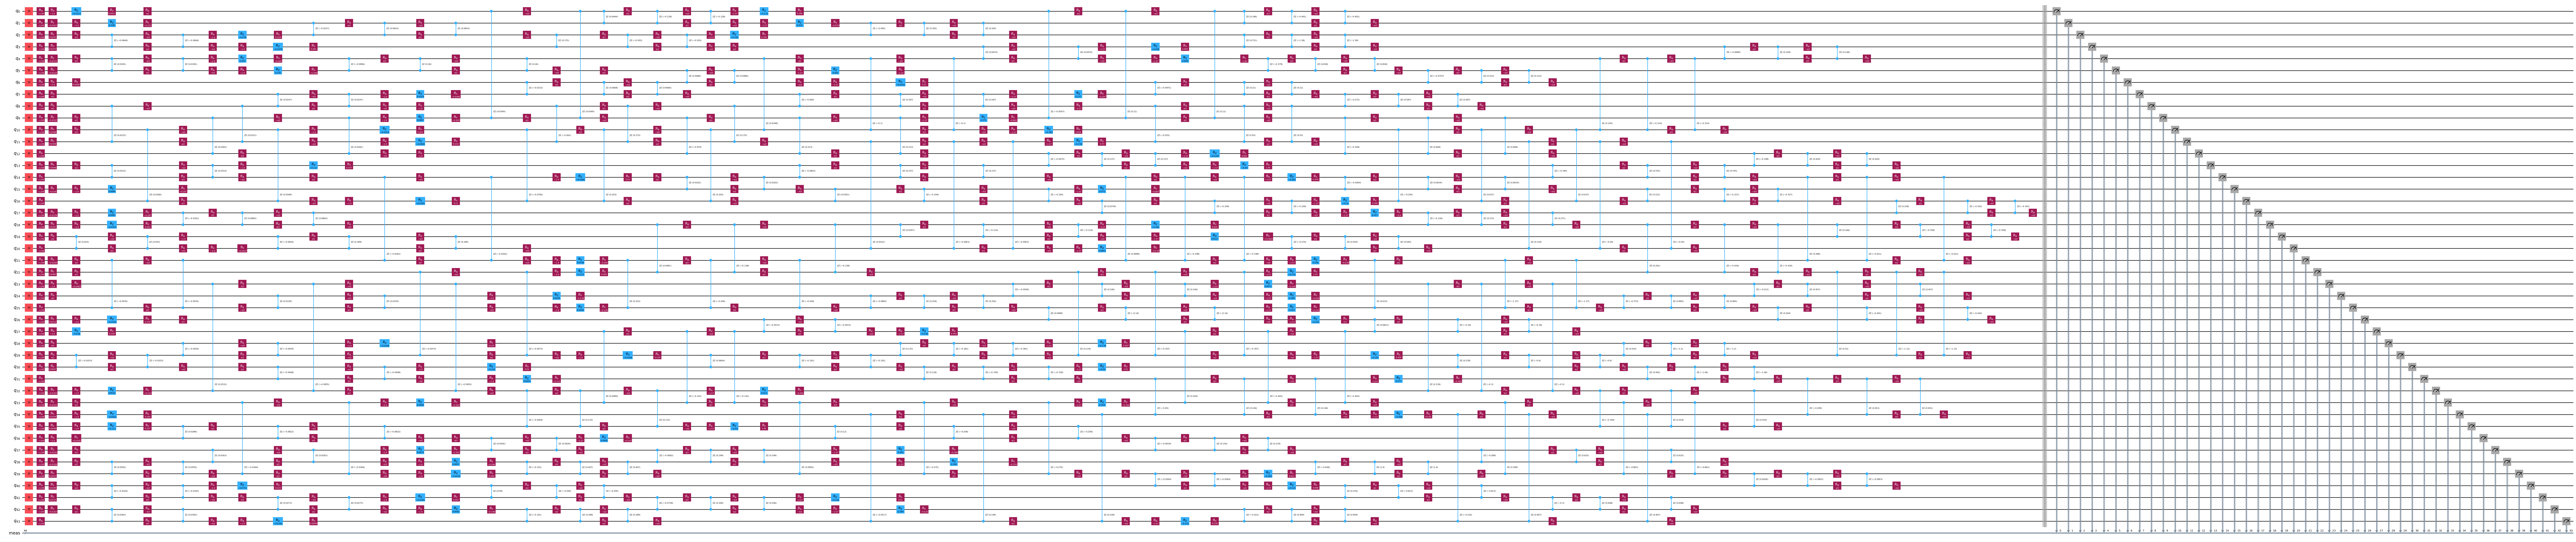

In [8]:
circ = dcqo_circ(num_nodes, hx, hz, row, col, data, y, dy, a1, threshold=threshold)
circ.draw("mpl", fold=-1)

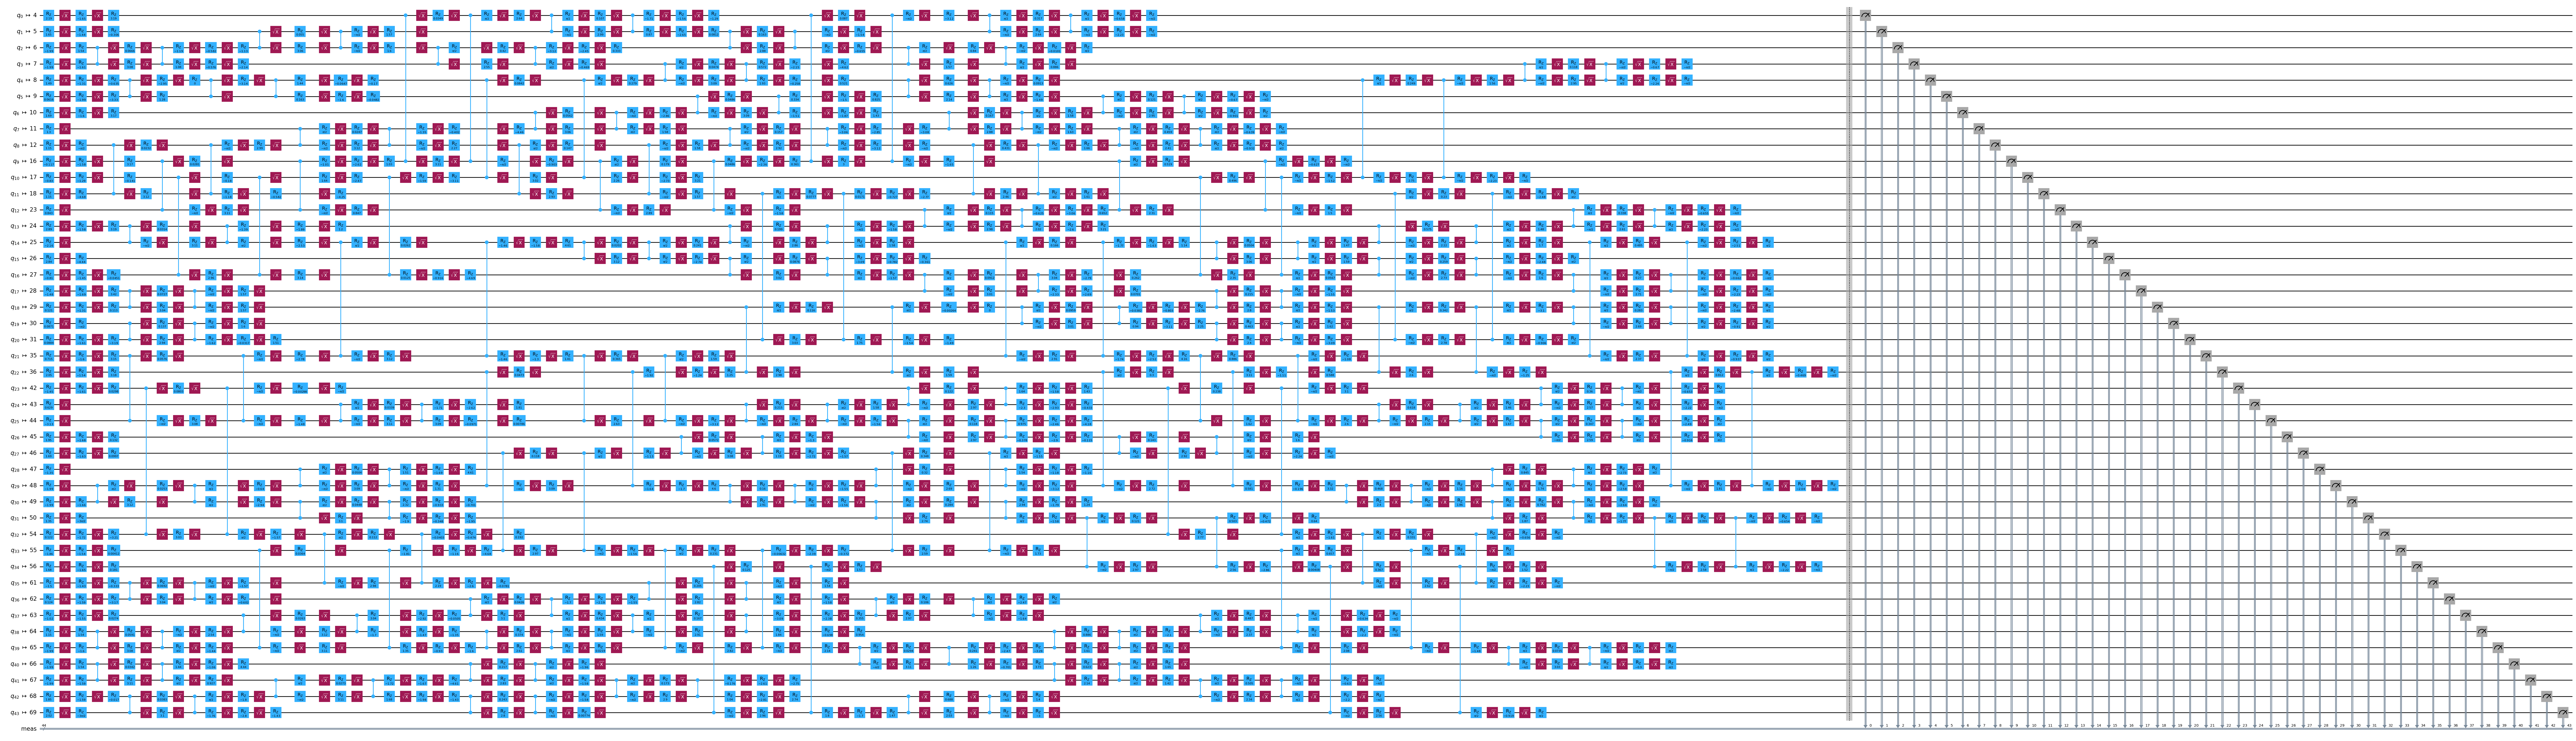

In [9]:
isa_circ = pm.run(circ)
isa_circ.draw("mpl", fold=-1, idle_wires=False)

In [10]:
# sampler = Sampler(backend, options=options)
sampler = Sampler(backend, options={"default_shots": shots})
# sampler.options.resilience_level = 1
sampler.options.dynamical_decoupling.enable = False
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

job = sampler.run([isa_circ])
print(job.job_id())

ctnnfcnsj17g00822nc0


In [18]:
circ = dcqo_circ(num_nodes, hx, hz, row, col, data, y, dy, a1, threshold=threshold)
isa_circ = pm.run(circ)

# sampler = Sampler(backend, options=options)
sampler = Sampler(backend, options={"default_shots": shots})
# sampler.options.resilience_level = 1
sampler.options.dynamical_decoupling.enable = False
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

job = sampler.run([isa_circ])
print(job.job_id())

ctnnj4gsj17g00822nqg


## Results

In [16]:
pauli_list = []

for i, d in enumerate(hz):
    pauli_list.append(("Z", [i], d))

for i, j, d in zip(row, col, data):
    pauli_list.append(("ZZ", [i, j], d))

# via triples and local Paulis with indices
Hf = SparsePauliOp.from_sparse_list(pauli_list, num_qubits=num_nodes)

### Sampler

In [25]:
# Layout 1
job = service.job("ctnnfcnsj17g00822nc0")
result = job.result()
quasi_dist_l1 = result[0].data.meas.get_counts()

# metadata
for key, val in result.metadata.items():
    print(f"'{key}' : {val},")

'version' : 2,


In [26]:
# Layout 1
job = service.job("ctnnj4gsj17g00822nqg")
result = job.result()
quasi_dist_l2 = result[0].data.meas.get_counts()

# metadata
for key, val in result.metadata.items():
    print(f"'{key}' : {val},")

'version' : 2,


In [27]:
objective_l1 = []
for k, p in quasi_dist_l1.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_l1.append(v)

objective_l2 = []
for k, p in quasi_dist_l2.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_l2.append(v)

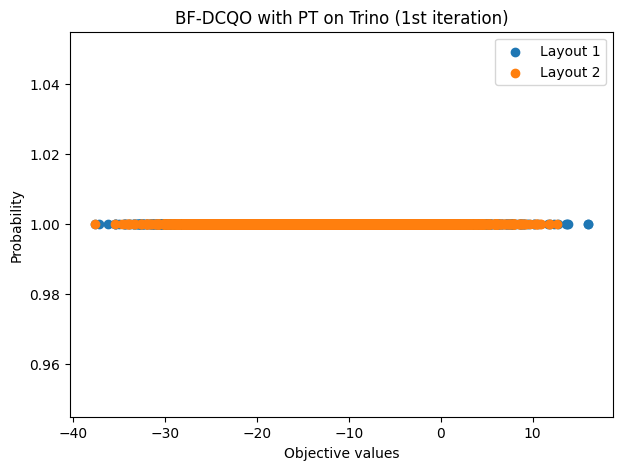

In [29]:
plt.figure(figsize=(7, 5))

plt.scatter(objective_l1, quasi_dist_l1.values())
plt.scatter(objective_l2, quasi_dist_l2.values())

# plt.xticks(rotation=90)
plt.xlabel("Objective values")
plt.ylabel("Probability")
plt.title("BF-DCQO with PT on Torino (1st iteration)")
plt.legend(["Layout 1", "Layout 2"])
plt.show()

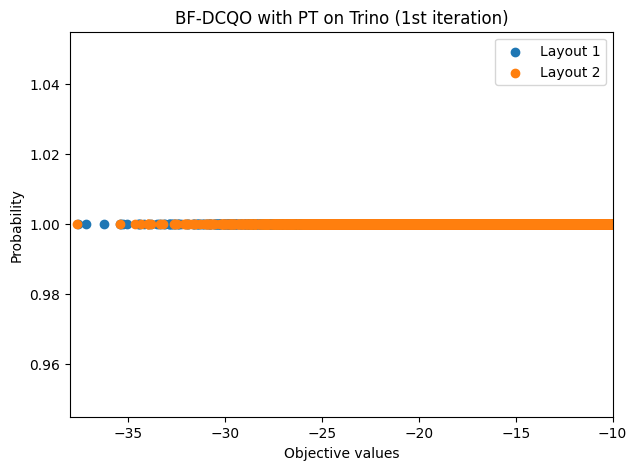

In [31]:
plt.figure(figsize=(7, 5))

plt.scatter(objective_l1, quasi_dist_l1.values())
plt.scatter(objective_l2, quasi_dist_l2.values())

# plt.xticks(rotation=90)
plt.xlabel("Objective values")
plt.ylabel("Probability")
plt.xlim(-38, -10)
plt.title("BF-DCQO with PT on Torino (1st iteration)")
plt.legend(["Layout 1", "Layout 2"])
plt.show()

In [30]:
print(min(objective_l1))
print(min(objective_l2))

-37.59055403013054
-37.63849661875416
